# Packages and definitions

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Start a session with the API.
qctrl = Qctrl()

### Define target operator

In [11]:
# We define the target operations via the ideal populations 
# at the end of the gate assuming we start from |0>:

ideal_pop_not = [0, 1, 0]     # NOT gate
ideal_pop_had = [0.5, 0.5, 0] # Hadamard gate

ideal_pop = ideal_pop_not

### Function to address the cloud qubit

In [14]:
def run_experiments(omegas, shot_count, control_count):
    
    controls = []
    
    for ii in range(control_count):
        controls.append(
            {"duration": duration, "values": omegas[ii]}
        )
    
    #print(controls)
    
    experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls   = controls,
        shot_count = shot_count,
    )
    
    # From the measurements we must get back an infidelity based on our target operation
    
    infidelities = np.zeros(len(controls))
    
    for k, measurement_counts in enumerate(experiment_results.measurements):
        p0 = measurement_counts.count(0) / shot_count
        p1 = measurement_counts.count(1) / shot_count
        p2 = measurement_counts.count(2) / shot_count
        
        infidelities[k] = (ideal_pop[0] - p0)**2 + (ideal_pop[1] - p1)**2 +(ideal_pop[2] - p2)**2

    # Return only infidelities between 0 and 1.
    return np.clip(infidelities, 0, 1)

### Defining parameters and initial experimental results

In [15]:
control_count = 20
segment_count = 10
duration      = 30
shot_count    = 2048

# Define standard deviation of the errors in the experimental results.
sigma = 0.01


# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, control_count)[:, None])
    * np.ones((control_count, segment_count))
)

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set, shot_count, control_count)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.


### Defining initialization for closed-loop optimization

In [16]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5,
    upper_bound=1e5,
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound= -1,        #-5 * np.pi / duration,
    upper_bound= 1,         # 5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)

### Closed-loop optimization

Best infidelity after 0 BOULDER OPAL optimization steps: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 8s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
Infidelity: 0.008703231811523438


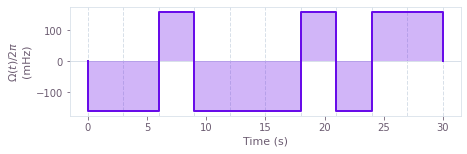

In [17]:
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3*sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, experiment_results)
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer = optimizer,
        results = results,
        test_point_count = control_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set, shot_count, control_count)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)

In [18]:
import jsonpickle.ext.numpy as jsonpickle_numpy
import jsonpickle
import numpy as np

jsonpickle_numpy.register_handlers()

not_control = {"duration": 30.0, "value": np.array(best_controls)}
json_not_control = jsonpickle.encode(not_control)
with open("not_control.json", "w") as file:
    file.write(json_not_control)